# Test code for evaluating the uvgap metric
 

### References:
- https://www.skatelescope.org/wp-content/uploads/2012/06/91_Figures-of-Merit-for-SKA-configuration-analysis-RevC.pdf
    - Newer definition of uvgap without gridding in the $|\mathrm{u}|$ direction
- http://www.skatelescope.org/uploaded/44041_107_Memo_Lal.pdf
    - Original uvgap reference
- http://arxiv.org/pdf/1501.01077.pdf
    - use of uvgap in analysis of simulations of IGM
- https://indico.skatelescope.org/event/262/session/2/contribution/7/material/slides/0.pdf
    - Talk on performance of SKA_1 baseline using uvgap
- https://www.skatelescope.org/wp-content/uploads/2013/08/82_Configurations-for-candidate-SKA-sites-design-and-analysis-1.0.pdf
    - Detailed analysis of array configurations for the candidate SKA sites
    - Details several figures of merit as well as results of uvgap

### Notes
- Measure of the average fractional increase in u-v length between u-v points in azimuthal wedges of the uv plane.
- Low values of UVGAP are achieved by having u-v points spread evenly in azimuth and logarithmically in radius on the u-v plane.
- Lower uvgap == better

In [5]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from pyuvwsim import evaluate_baseline_uvw_ha_dec
from math import radians, degrees, pi

In [2]:
# Load CASA VLA-C XYZ (ECEF) coordinates.
coords = np.loadtxt('../models/vla.c.cfg')
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

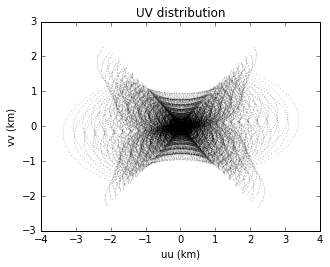

In [3]:
# Generate UV coordinates
lat = radians(34 + 4.0/60.0 + 43.497 / 3600.0)  # http://www.vla.nrao.edu/genpub/overview/
lon = -radians(107 + 37 / 60 + 3.819 / 3600.0)
dec = radians(-30.0)
ha_min = -4
ha_max = +4
num_times = ((ha_max - ha_min) * 60) // 10  # 1 sample every 10 min

uu, vv = list(), list()
for i, ha in enumerate(np.linspace((ha_min/24)*(2*pi), (ha_max/24)*(2*pi), num_times)):
    # print(i, degrees(ha), degrees(dec), degrees(ha - lon))
    uu_, vv_, _ = evaluate_baseline_uvw_ha_dec(x, y, z, ha - lon, dec)
    uu, vv = np.append(uu, uu_), np.append(vv, vv_)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu / 1.0e3, vv / 1.0e3, '.', color='k', ms=2.0, alpha=0.1)
ax.plot(-uu / 1.0e3, -vv / 1.0e3, '.', color='k', ms=2.0, alpha=0.1)
ax.set_xlabel('uu (km)')
ax.set_ylabel('vv (km)')
ax.set_title('UV distribution')
plt.show()

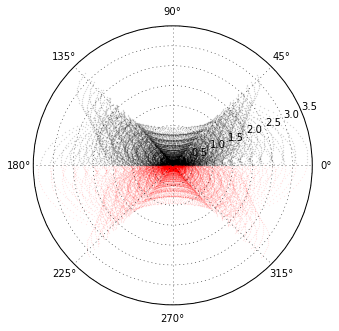

In [4]:
# Convert to r, theta
uu_ = np.copy(uu)
vv_ = np.copy(vv)
r = (uu_**2 + vv_**2)**0.5
theta = np.arctan2(vv_, uu_)
theta[theta < 0.0] += pi

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, r / 1.0e3, 'k.', ms=2.0, alpha=0.1)
ax.plot(theta - pi, r / 1.0e3, 'r.', ms=2.0, alpha=0.05)
plt.show()

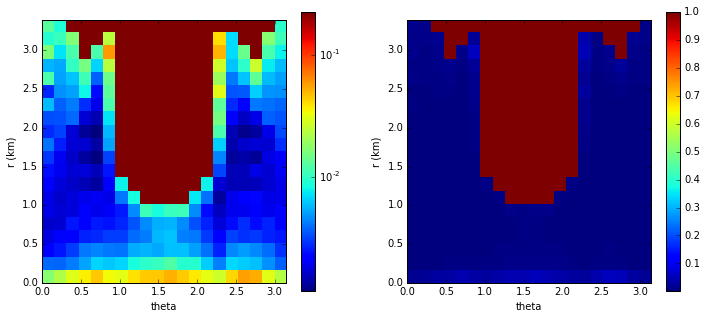

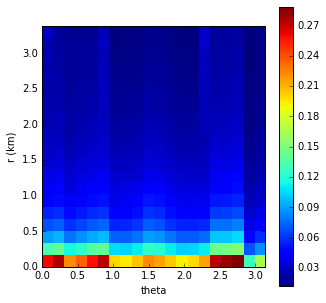

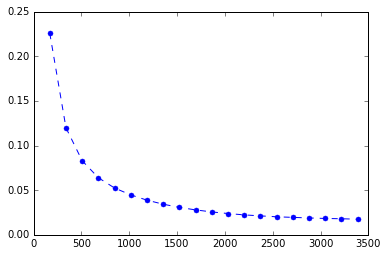

169.359912 0.225746
338.719824 0.119818
508.079735 0.082985
677.439647 0.063905
846.799559 0.052396
1016.159471 0.044689
1185.519382 0.038796
1354.879294 0.034271
1524.239206 0.030713
1693.599118 0.027893
1862.959029 0.025619
2032.318941 0.023831
2201.678853 0.022303
2371.038765 0.021190
2540.398676 0.020178
2709.758588 0.019518
2879.118500 0.018880
3048.478412 0.018299
3217.838323 0.017983
3387.198235 0.017461


In [36]:
num_bins = 20
r_max = r.max()
theta_edges = np.linspace(0, pi, num_bins + 1)
r_edges = np.linspace(0, r_max, num_bins + 1)
theta_idx = np.digitize(theta, theta_edges)

uv_gap_im = np.zeros((num_bins, num_bins))
uv_gap_im_2 = np.zeros((num_bins, num_bins))

# Loop over theta bins
for j in range(num_bins):
    r_values = r[theta_idx == 1 + j]
    r_values = np.append(r_values, 0.0)
    t_values = theta[theta_idx == 1 + j]
    t_values = np.append(t_values, 0.0)
    order = np.argsort(r_values)
    r_values = r_values[order]
    t_values = t_values[order]
    r_diff = np.diff(r_values)
    r_diff_norm = r_diff / r_values[1:]
    
    # Loop over r bins (within the theta bin)
    for i in range(num_bins):
        d0 = np.where(r_values <= r_edges[i])[0][-1]
        d1 = np.where(r_values > r_edges[i + 1])[0]
        d1 = r_values.shape[0] - 1 if len(d1) == 0 else d1[0]
        bin_diffs = r_diff_norm[d0:d1]
        uv_gap_im[j, i] = numpy.nanmean(bin_diffs) if bin_diffs.shape[0] > 0 else 1.0

        rmax_ = r_edges[i + 1]
        x_b = np.append(r_values, rmax_)
        x_b = np.sort(x_b)
        x_b = x_b[x_b < rmax_]
        uv_gap_im_2[j, i] = np.sum(np.diff(x_b)**2 / x_b[1:]) / rmax_
    
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
image = np.transpose(uv_gap_im)
extent = [theta_edges[0], theta_edges[-1],
          r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
im = ax.imshow(image, interpolation='nearest', 
               origin='lower', cmap='jet', extent=extent, 
               norm=LogNorm(vmax=0.225))
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('theta')
ax.set_ylabel('r (km)')

ax = fig.add_subplot(122)
image = np.transpose(uv_gap_im)
extent = [theta_edges[0], theta_edges[-1],
          r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
im = ax.imshow(image, interpolation='nearest', 
               origin='lower', cmap='jet', extent=extent)
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('theta')
ax.set_ylabel('r (km)')
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
image = np.transpose(uv_gap_im_2)
extent = [theta_edges[0], theta_edges[-1],
          r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
im = ax.imshow(image, interpolation='nearest', 
               origin='lower', cmap='jet', extent=extent)
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('theta')
ax.set_ylabel('r (km)')
plt.show()

# FIXME(BM) convert to radial profile and compare to antconfig
uv_gap_r = np.zeros(num_bins)
for i in range(num_bins):
    uv_gap_r[i] = np.mean(uv_gap_im_2[:, i])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r_edges[1:], uv_gap_r, '.--', ms=10.0)
plt.show()

for i in range(num_bins):
    print('%f %f' % (r_edges[i+1], uv_gap_r[i]))


(20, 4)


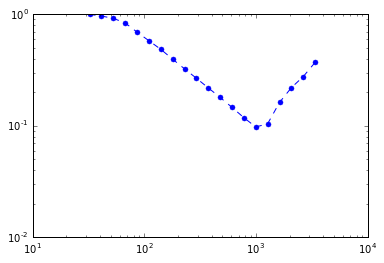

In [6]:
data = np.loadtxt('/Users/bmort/Desktop/ant_conf_metrics.txt.20x3.txt')
print(data.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data[:, 1], data[:, 3], '.--', ms=10)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


In [69]:
from bokeh.plotting import figure, output_notebook, show, vplot
from bokeh.models import SingleIntervalTicker, LinearAxis
# output_notebook()
TOOLS = "pan,box_zoom,reset,save"
plot = figure(width=700, height=300, tools=TOOLS, y_axis_type='log', 
              x_axis_type='log', x_range=[10, 10000], 
              title='iAntConfig uvgap')
plot.scatter(data[:, 1], data[:, 3])
plot.xaxis.axis_label='radius'
plot.xaxis.axis_label_text_font_size='10pt'
plot.yaxis.axis_label='uvgap'
plot.yaxis.axis_label_text_font_size='10pt'
plot.yaxis.major_label_text_font_size='10pt'
plot.yaxis[0].ticker.desired_num_ticks = 2
show(plot)